<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Kaggle Competitions: Learning Agency Lab - Automated Essay Scoring 2.0  @FIT-HCMUS, VNU-HCM 📌
</div>

<div style="text-align: center; background-color: #b1d1ff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 01 - Data preprocessing 📌
</div>

# Import các thư viện cần thiết


In [74]:
# Comment this line of code if you already have those downloaded
!pip install --no-index --no-deps /kaggle/input/aes-hcmus-whl/pyphen-0.15.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/aes-hcmus-whl/textstat-0.7.3-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/aes-hcmus-whl/pyspellchecker-0.8.1-py3-none-any.whl
print("\nDone installing")

Processing /kaggle/input/aes-hcmus-whl/pyphen-0.15.0-py3-none-any.whl
pyphen is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/aes-hcmus-whl/textstat-0.7.3-py3-none-any.whl
textstat is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/aes-hcmus-whl/pyspellchecker-0.8.1-py3-none-any.whl
pyspellchecker is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.

Done installing


In [75]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [76]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk import punkt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from spellchecker import SpellChecker

import textstat

import warnings
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv
/kaggle/input/aes-hcmus-whl/pyproject_toml-0.0.10-py3-none-any.whl
/kaggle/input/aes-hcmus-whl/textstat-0.7.3-py3-none-any.whl
/kaggle/input/aes-hcmus-whl/pyspellchecker-0.8.1-py3-none-any.whl
/kaggle/input/aes-hcmus-whl/pyphen-0.15.0-py3-none-any.whl


# Khám phá dữ liệu

## Đọc dữ liệu

In [77]:
df_train = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')
df_test = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')

# df_train = pd.read_csv('../data/raw/train.csv')
# df_test = pd.read_csv('../data/raw/test.csv')

In [78]:
df_train

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3
...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2
17303,ffddf1f,Technology has changed a lot of ways that we l...,4
17304,fff016d,If you don't like sitting around all day than ...,2
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1


### Có bao nhiêu dòng và cột trong dữ liệu?

In [79]:
df_train.shape

(17307, 3)

### Ý nghĩa của mỗi dòng là gì?


Each line contains id, content of essay and its score.

### Có dòng nào bị trùng lặp không?

In [80]:
num_duplicated_rows = df_train.duplicated().sum()
if num_duplicated_rows == 0:
    print(f"Data have no duplicated line!")
else:
    if num_duplicated_rows > 1:
        ext = "lines"
    else:
        ext = "line"
    print(f"Data have {num_duplicated_rows} duplicated " + ext + ". Please de-deduplicate your raw data.!")

Data have no duplicated line!


### Ý nghĩa mỗi cột là gì?

- **id**: id of essay
- **full_text**: content of essay
- **score**: score of essay

### What data type does each column currently have?

In [81]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


# Khám phá dữ liệu kiểu số

### For each column with numeric data type, how are the values distributed?
- Percentage (from 0 to 100) of missing values
- The min
- The lower quartile (tứ phân vị thứ nhất)
- The median (tứ phân vị thứ hai)
- The upper quartile (tứ phân vị thứ ba)
- The max

In [82]:
def missing_ratio(x):
    missing_ratio = x.isnull().sum()/len(x)
    return missing_ratio.round(1)

def lower_quartile(x):
    return x.quantile(0.25).round(1)

def median(x):
    return x.median().round(1)

def upper_quartile(x):
    return x.quantile(0.75).round(1)

# Tạo DataFrame trống
num_col_info_df = pd.DataFrame(df_train.select_dtypes(include=[np.number]))
num_col_info_df = num_col_info_df.agg([ missing_ratio,"min",lower_quartile, median,upper_quartile,"max"])

In [83]:
num_col_info_df

,score
missing_ratio,0.0
min,1.0
lower_quartile,2.0
median,3.0
upper_quartile,4.0
max,6.0


# Explore categorical data

### For each column with a non-numeric data type, how are the values distributed?
- Percentage (from 0 to 100) of missing values
- Number of values (the values here are different values and we do not consider missing values): with columns whose type is categorical, it is a set with a finite number of categories. Directly counting the number of values in these columns doesn't make much sense, so it's better to count the number of elements of all types. (Số lượng các giá trị (các giá trị ở đây là các giá trị khác nhau và ta không xét giá trị thiếu): với cột mà có kiểu là categorical, nó là một tập hợp có số lượng hữu hạn các loại. Việc đếm trực tiếp số lượng các giá trị trong những cột này không có nhiều ý nghĩa, nên tốt hơn hết là mà sẽ đếm số lượng phần tử các loại.)
- The percentage (from 0 to 100) of each value is sorted by decreasing percentage (we do not consider missing values, the ratio is the ratio compared to the number of non-missing values): you use a dictionary to store , key is the value, value is the percentage; With the column corresponding to each type, the method is similar to above.

I will drop id column because it is not meaning for analysis.

In [84]:
cat_col_info_df = df_train['full_text']
def missing_ratio(x):
    missing_ratio = x.isnull().sum()/len(x)
    return missing_ratio
    
def num_values(x):
    result = x.value_counts().to_dict()
    return result


def value_ratios(x):

    result = {}
    counterDict = num_values(x)
    total = sum(counterDict.values())
    for key,val in counterDict.items():
        result[key] = val / total
    return result



cat_col_info_df = cat_col_info_df.agg([missing_ratio, num_values, value_ratios])


In [85]:
cat_col_info_df

missing_ratio                                                  0.0
num_values       {'Many people have car where they live. The th...
value_ratios     {'Many people have car where they live. The th...
Name: full_text, dtype: object

# EDA

## Số từ 

In [86]:
df_train['word_count'] = df_train['full_text'].apply(lambda x: len(x.split()))
df_test['word_count'] = df_test['full_text'].apply(lambda x: len(x.split()))

## Độ dài của văn bản

In [87]:
df_train['essay_length'] = df_train['full_text'].str.len()
df_test['essay_length'] = df_test['full_text'].str.len()

## Số câu

In [88]:
# Adding a new column 'sentences_count' that counts the sentences in 'full_text'
df_train['sentences_count'] = df_train['full_text'].str.count(r'\.')
df_test['sentences_count'] = df_test['full_text'].str.count(r'\.')


## Số đoạn

In [89]:

# Adding a new column 'paragraph_count' that counts the paragraphs in 'full_text'
df_train['paragraph_count'] = df_train['full_text'].str.count(r'\n') + 1
df_test['paragraph_count'] = df_test['full_text'].str.count(r'\n') + 1

In [90]:
df_train.head(5)

,essay_id,full_text,score,word_count,essay_length,sentences_count,paragraph_count
0,000d118,Many people have car where they live. The thin...,3,498,2677,13,1
1,000fe60,I am a scientist at NASA that is discussing th...,3,332,1669,19,9
2,001ab80,People always wish they had the same technolog...,4,550,3077,24,7
3,001bdc0,"We all heard about Venus, the planet without a...",4,451,2701,23,9
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,373,2208,15,11


In [91]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   essay_id         17307 non-null  object
 1   full_text        17307 non-null  object
 2   score            17307 non-null  int64 
 3   word_count       17307 non-null  int64 
 4   essay_length     17307 non-null  int64 
 5   sentences_count  17307 non-null  int64 
 6   paragraph_count  17307 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 946.6+ KB


# Visualization

## Phân phối của cột score

count    17307.000000
mean         2.948402
std          1.044899
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: score, dtype: float64


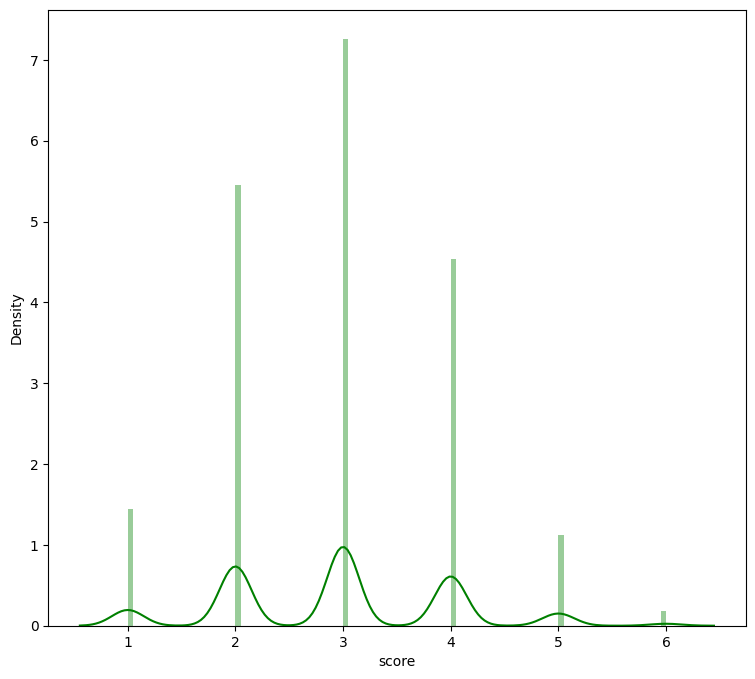

In [92]:
print(df_train['score'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df_train['score'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Biểu đồ scatter thể hiện phân phối giữa word_count và score

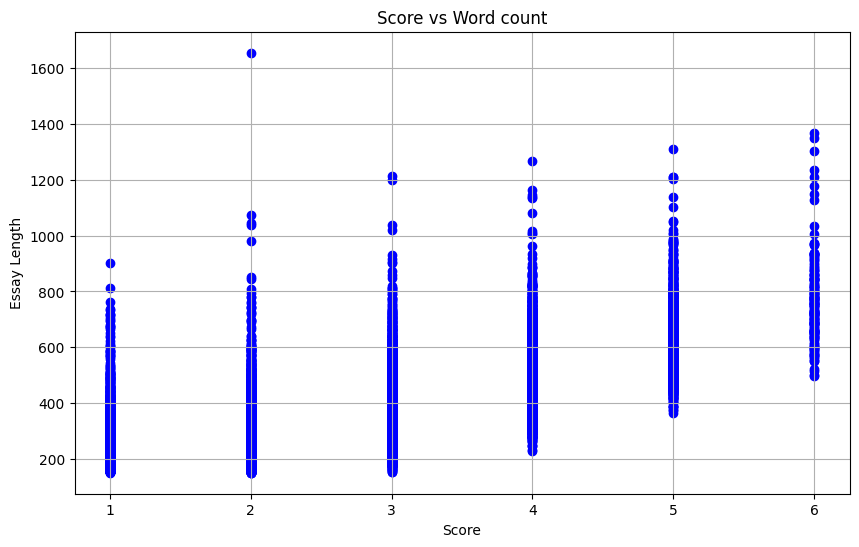

In [93]:
plt.figure(figsize=(10, 6))
plt.scatter(df_train['score'], df_train['word_count'], color='blue')
plt.title('Score vs Word count')
plt.xlabel('Score')
plt.ylabel('Essay Length')
plt.grid(True)
plt.show()

## Biểu đồ scatter thể hiện phân phối giữa essay_length và score

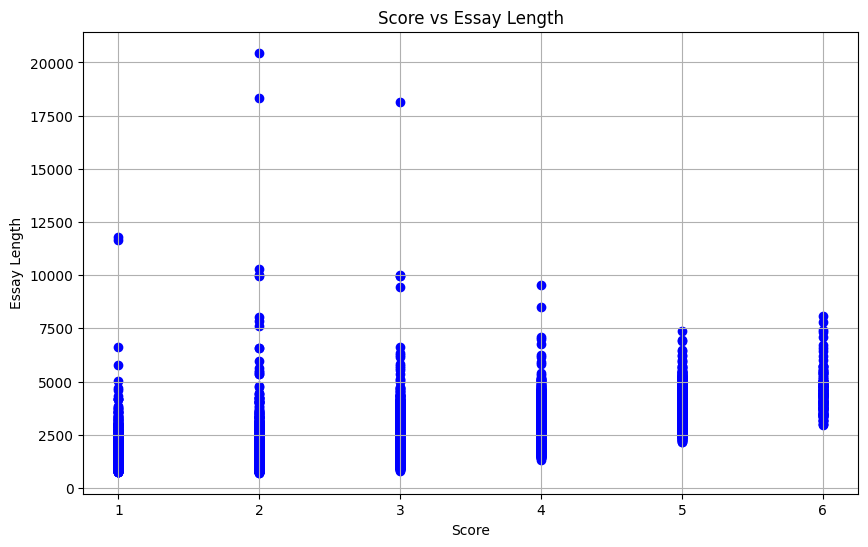

In [94]:
plt.figure(figsize=(10, 6))
plt.scatter(df_train['score'], df_train['essay_length'], color='blue')
plt.title('Score vs Essay Length')
plt.xlabel('Score')
plt.ylabel('Essay Length')
plt.grid(True)
plt.show()

### Loại bỏ các outliers

In [95]:
# # Tìm các dòng có giá trị LotFrontage lớn hơn 300 và lấy index của chúng

# rows_to_drop = df_train.query('(essay_length > 4000 & score == 1) | (essay_length > 5000 & score == 2) | (essay_length > 5000 & score == 3) | (essay_length > 5600 & score == 4) | (essay_length > 6000 & score == 5) | (essay_length > 6000 & score == 6)').index

# # Xóa các dòng có index tương ứng

# df_train.drop(rows_to_drop, inplace=True)

In [96]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   essay_id         17307 non-null  object
 1   full_text        17307 non-null  object
 2   score            17307 non-null  int64 
 3   word_count       17307 non-null  int64 
 4   essay_length     17307 non-null  int64 
 5   sentences_count  17307 non-null  int64 
 6   paragraph_count  17307 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 946.6+ KB


## Scatter plot between score and Number of sentences

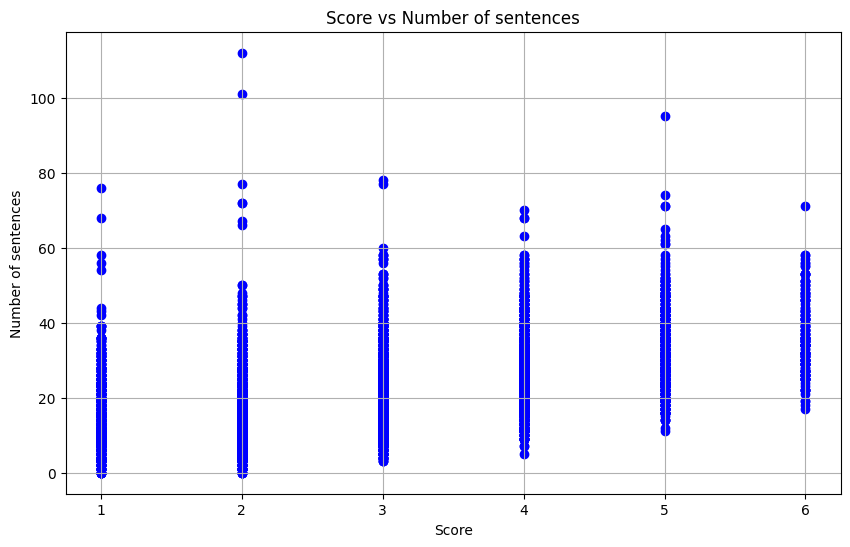

In [97]:
plt.figure(figsize=(10, 6))
plt.scatter(df_train['score'], df_train['sentences_count'], color='blue')
plt.title('Score vs Number of sentences')
plt.xlabel('Score')
plt.ylabel('Number of sentences')
plt.grid(True)
plt.show()

### Loại bỏ các outliers

In [98]:
# # Tìm các dòng có giá trị LotFrontage lớn hơn 300 và lấy index của chúng

# rows_to_drop = df_train.query('sentences_count > 60 | (sentences_count > 50 & score == 1)').index

# # Xóa các dòng có index tương ứng

# df_train.drop(rows_to_drop, inplace=True)

In [99]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   essay_id         17307 non-null  object
 1   full_text        17307 non-null  object
 2   score            17307 non-null  int64 
 3   word_count       17307 non-null  int64 
 4   essay_length     17307 non-null  int64 
 5   sentences_count  17307 non-null  int64 
 6   paragraph_count  17307 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 946.6+ KB


## Scatter plot between score and Number of paragraphs

In [100]:
plt.figure(figsize=(10, 6))
plt.scatter(df_train['score'], df_train['paragraph_count'], color='blue')
plt.title('Score vs Number of paragraphs')
plt.xlabel('Score')
plt.ylabel('Number of paragraphs')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

### Loại bỏ các outliers

In [ ]:
# # Tìm các dòng có giá trị LotFrontage lớn hơn 300 và lấy index của chúng

# rows_to_drop = df_train.query('paragraph_count > 80 | (paragraph_count > 55 & score == 1 ) | (paragraph_count >60 & score == 2 ) | (paragraph_count > 30  & score == 5) | (paragraph_count > 25  & score == 6)').index

# # Xóa các dòng có index tương ứng

# df_train.drop(rows_to_drop, inplace=True)

In [ ]:
df_train.info()

# Tiền xử lý dữ liệu

## Xử lý các từ viết tắt

### Tìm tất cả những từ viết tắt trong văn bản

In [ ]:
contraction_list = []
for text in df_train['full_text']:
    # Tìm tất cả các từ có dấu nháy đơn
    contractions = re.findall(r"\b\w*'\w*\b", text)
    # Thêm các từ tìm được vào danh sách
    contraction_list.extend(contractions)
contraction_list = list(set(contraction_list))


### Kiểm tra chính tả tất cả từ viết tắt nếu từ nào sai thì loại khỏi list

In [ ]:
# Khởi tạo SpellChecker
spell = SpellChecker()

def misspelled_words(text):
    words = text.split()
    misspelled_words = spell.unknown(words)
    return misspelled_words

# Lọc các từ sai chính tả ra khỏi contraction_list
contraction_list = [word for word in contraction_list if word not in misspelled_words(word)]


### Chuyển các từ viết tắt thành dạng đầy đủ

In [ ]:
contractions = dict.fromkeys(contraction_list)

# Hàm chuyển đổi các từ viết tắt thành dạng đầy đủ
def expand_contractions(word):
    if "'s" in word:
        return word.split("'")[0] + " is"
    elif "'ll" in word:
        return word.split("'")[0] + " will"
    elif "'ve" in word:
        return word.split("'")[0] + " have"
    elif "'d" in word:
        return word.split("'")[0] + " would"
    elif "n't" in word:
        return word.split("n't")[0] + " not"
    else:
        return word

# Áp dụng hàm expand_contractions cho giá trị của mỗi key trong dictionary contractions
for key in contractions:
    contractions[key] = expand_contractions(key)
    
# Xử lý các trường hợp đặc biệt không thuộc hàm
contractions["ma'am"] = "madame"
contractions["won't"] = "will not"
contractions["y'all"] = "you all"
contractions["shan't"] = "shall not"
contractions["i've"] = "I have"


In [ ]:
for index, essay in df_train['full_text'].items():
    original_essay = essay  # Lưu trữ essay ban đầu
    words = essay.split()  # Tách essay thành các từ
    replaced = False  # Biến để theo dõi xem có sự thay thế nào không

    # Duyệt qua mỗi từ trong essay
    for word in words:
        # Kiểm tra nếu từ có trong dict contractions
        if word in contractions:
            essay = essay.replace(word, contractions[word])
            replaced = True  # Đánh dấu là đã có thay thế
    
    # Cập nhật essay trong DataFrame chỉ nếu có sự thay thế
    if replaced:
        df_train.at[index, 'full_text'] = essay
    else:
        
        df_train.at[index, 'full_text'] = original_essay  # Giữ nguyên essay ban đầu

# test 
for index, essay in df_test['full_text'].items():
    original_essay = essay  # Lưu trữ essay ban đầu
    words = essay.split()  # Tách essay thành các từ
    replaced = False  # Biến để theo dõi xem có sự thay thế nào không

    # Duyệt qua mỗi từ trong essay
    for word in words:
        # Kiểm tra nếu từ có trong dict contractions
        if word in contractions:
            essay = essay.replace(word, contractions[word])
            replaced = True  # Đánh dấu là đã có thay thế
    
    # Cập nhật essay trong DataFrame chỉ nếu có sự thay thế
    if replaced:
        df_test.at[index, 'full_text'] = essay
    else:
        df_test.at[index, 'full_text'] = original_essay  # Giữ nguyên essay ban đầu


## Thực hiện tiền xử lý các từ trong văn bản

In [ ]:

# Hàm để preprocessing dữ liệu
def clean_data(essay):
    # Chuyển đổi văn bản thành chữ thường
    # essay_lower = essay.lower()

    # Chuyển các hậu tố 't thành not
    essay_cleaned = essay.lower()
    # Loại bỏ các ký tự không phải chữ cái, số hoặc dấu câu
    essay_cleaned = re.sub(r'[^a-zA-Z0-9\s.,?!:;\'"()-]', '', essay_cleaned)
    
    # Tokenization chia nhỏ văn bản nếu có các từ bị dính liền
    words = word_tokenize(essay_cleaned)
    
    # Lemmatization để chuyển đổi các từ về dạng gốc 
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Nối các từ đã được Lemmatization
    processed_essay = ' '.join(lemmatized_words)
    processed_essay = re.sub(r"``\s*", ' "', processed_essay)
    processed_essay = re.sub(r"''", '"', processed_essay)

    # Bỏ khoảng trắng trước dấu câu
    text_processed = re.sub(r'\s([.,?!:;\'"()-])', r'\1', processed_essay)

    return text_processed

In [ ]:
df_train['clean_text'] = df_train['full_text'].apply(clean_data)
df_test['clean_text'] = df_test['full_text'].apply(clean_data)
df_train = df_train.drop(['essay_id','full_text'], axis = 1)
# test = clean_data(df_train['full_text'][0])
# print(test)

## Sử dụng thư viện "textstat" để tạo ra các feature mới

1. textstat.flesch_reading_ease
    * Trả về Điểm dễ đọc theo Phương Pháp Flesch.
    * Dùng để đánh giá mức độ dễ đọc của văn bản.
    * Bảng đánh giá độ dễ đọc (dựa trên Flesch Reading Ease Score)
      | Score  | Difficulty  | 
      |------------|------------|
      | 90-100 | Very Easy | 
      | 80-89 | Easy | 
      | 70-79 | Fairly Easy | 
      | 60-69 | Standard |
      | 50-59 | Fairly Difficult |
      | 30-49 | Difficult |
      | 0-29 | Very Confusing |
2. textstat.flesch_kincaid_grade
    * Trả về điểm Flesch-Kincaid.
    * Dùng để đánh giá mức độ khó đọc của văn bản. 
    * Điểm số Flesch-Kincaid tương ứng với độ phù hợp với học sinh lớp tương ứng (ví dụ Flesch-Kincaid Grade = 9.3 thì văn bản đó phù hợp với học sinh lớp 9)

3. textstat.smog_index
    * Trả về chỉ số SMOG.
    * SMOG grade là một cách tính độ đọc được ước lượng số năm học cần thiết để hiểu được một đoạn văn bản. SMOG là viết tắt của "Simple Measure of Gobbledygook".

4. textstat.coleman_liau_index
    * Trả về cấp độ học vụ của văn bản bằng Công thức Coleman-Liau.
    * Coleman-Liau Index đánh giá mức độ dễ hiểu của một văn bản. Kết quả của nó xấp xỉ với cấp độ trình độ ở Mỹ cần thiết để hiểu văn bản.

5. textstat.automated_readability_index
    * Trả về chỉ số ARI.
    * Automated readability index (ARI) là một bài kiểm tra độ đọc được cho văn bản tiếng Anh, được thiết kế để đánh giá mức độ hiểu được của văn bản. Nó tạo ra một biểu diễn gần đúng về cấp độ học vụ ở Mỹ cần thiết để hiểu được văn bản.

6. textstat.dale_chall_readability_score
    * Trả về cấp độ học vị sử dụng Công thức New Dale-Chall.
    * Dale–Chall readability formula là một bài kiểm tra tính dễ đọc, cung cấp một phép đo số học về mức độ khó hiểu mà người đọc phải đối diện khi đọc một văn bản. Nó sử dụng một danh sách 3000 từ mà các nhóm học sinh lớp tư ở Mỹ có thể hiểu một cách đáng tin cậy, coi mọi từ không có trong danh sách đó là khó.
    * Bảng đánh giá
        | Score  | Understood by  | 
        |------------|------------|
        | 4.9 or lower | average 4th-grade student or lower | 
        | 5.0–5.9 | average 5th or 6th-grade student | 
        | 6.0–6.9 | average 7th or 8th-grade student | 
        | 7.0–7.9 | average 9th or 10th-grade student |
        | 8.0–8.9 | average 11th or 12th-grade student |
        | 9.0–9.9 | average 13th to 15th-grade (college) student |

7. textstat.difficult_words
    * Trả về số lượng Difficult Word.
    * Difficult Words là số lượng từ trong văn bản không nằm trong danh sách các từ thông dụng. Đây là một chỉ số phụ trợ giúp đánh giá độ khó của văn bản. 

8. textstat.linsear_write_formula
    * Trả về cấp độ học vụ sử dụng công thức viết Linsear.
    * Linsear Write là một chỉ số đánh giá độ đọc cho văn bản tiếng Anh, được cho là phát triển cho Không quân Hoa Kỳ để giúp họ tính toán độ dễ đọc của các hướng dẫn kỹ thuật của họ. Đây là một trong nhiều chỉ số đánh giá độ đọc nhưng được thiết kế đặc biệt để tính toán cấp độ trình độ học vị của Hoa Kỳ.

9. Gunning Fog Index:
    - Được phát triển bởi Robert Gunning vào năm 1952.
    - Chỉ số này ước tính số năm giáo dục mà một người cần để hiểu được văn bản khi đọc lần đầu tiên.
    - "Complex Words" là những từ có ba âm tiết trở lên.
10. Text Standard:
    - Đây không phải là một chỉ số cụ thể mà là một công cụ hoặc phương pháp tổng hợp để đánh giá độ dễ đọc của văn bản bằng cách sử dụng nhiều chỉ số khác nhau.
    - Có thể kết hợp nhiều chỉ số như Flesch-Kincaid, Gunning Fog, SMOG, Coleman-Liau, v.v. để đưa ra một kết quả tổng quát.
11. Fernández Huerta:
    - Một chỉ số đọc hiểu cho văn bản tiếng Tây Ban Nha, tương tự như Flesch-Kincaid trong tiếng Anh.
12. Szigriszt-Pazos:
    - Là một chỉ số đọc hiểu cho văn bản tiếng Tây Ban Nha.
13. Gutiérrez Polini:
    - Đây là một chỉ số đọc hiểu khác dành cho văn bản tiếng Tây Ban Nha.
14. Crawford:
    - Một chỉ số đọc hiểu không phổ biến như các chỉ số khác.
    - Được phát triển để đánh giá mức độ khó của văn bản dựa trên độ dài câu và số lượng từ khó hiểu.
15. Gulpease Index:
    - Chỉ số đọc hiểu cho văn bản tiếng Ý.
16. Osman:
    - Đây là một chỉ số đọc hiểu không quá phổ biến, có thể liên quan đến đánh giá mức độ dễ đọc của văn bản bằng một số yếu tố tương tự các chỉ số khác.

In [ ]:
def textstat_features(text: str) -> dict:
    features = {}
    features['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
    features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(text)
    features['smog_index'] = textstat.smog_index(text)
    features['coleman_liau_index'] = textstat.coleman_liau_index(text)
    features['automated_readability_index'] = textstat.automated_readability_index(text)
    features['dale_chall_readability_score'] = textstat.dale_chall_readability_score(text)
    features['difficult_words'] = textstat.difficult_words(text)
    features['linsear_write_formula'] = textstat.linsear_write_formula(text)
    return features

In [ ]:
# Apply textstat_features to each row in the clean_text column and create a DataFrame from the result
features_df = df_train['clean_text'].apply(lambda text: pd.Series(textstat_features(text)))

# Concatenate the original DataFrame with the new features DataFrame
df_train = pd.concat([df_train, features_df], axis=1)

# test 
features_df = df_test['clean_text'].apply(lambda text: pd.Series(textstat_features(text)))

# Concatenate the original DataFrame with the new features DataFrame
df_test = pd.concat([df_test, features_df], axis=1)

In [ ]:
df_train

## Tạo ra cột đếm số lượng từ sai chính tả

In [ ]:
# Khởi tạo đối tượng SpellChecker
spell = SpellChecker()

def count_misspelled_words(text):
    # Loại bỏ tất cả các dấu đặc biệt
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tách các từ trong văn bản
    words = text.split()
    
    # Kiểm tra các từ sai chính tả
    misspelled_words = spell.unknown(words)

    return len(misspelled_words)

In [ ]:
# Loại bỏ những dòng có giá trị NaN trong cột 'clean_text'
# df_train = df_train.dropna(subset=['clean_text'])
# df_train = df_train.drop('full_text', axis = 1)
df_train['misspelled_count'] = df_train['clean_text'].apply(count_misspelled_words)
df_test['misspelled_count'] = df_test['clean_text'].apply(count_misspelled_words)

In [ ]:
df_train

# Save data

In [ ]:
df_train.to_csv('/kaggle/working/train_processed.csv', index=False)
df_test.to_csv('/kaggle/working/test_processed.csv', index=False)


# Model

In [ ]:
# Use for pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import cohen_kappa_score, f1_score, make_scorer

# Use for training model
from optuna.samplers import TPESampler
from scipy.stats import randint
from nltk.tokenize import word_tokenize
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier 
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

### Cài đặt Pipeline

**Câu hỏi**: Pipeline là gì?

> Pipeline là một cách để mã hóa và tự động hóa các công đoạn và quy trình làm việc cần thiết để tạo ra một mô hình học máy. Pipeline bao gồm nhiều bước tuần tự thực hiện mọi thứ từ trích xuất dữ liệu (data extraction) và tiền xử lý dữ liệu (preprocessing data) cho đến huấn luyện và triển khai mô hình.

> Đối với các hệ thống sử dụng mô hình ML, thì quy trình pipeline là phần trung tâm của sản phẩm. Nó đóng gói toàn bộ các phương pháp xử lý dữ liệu tốt nhất để tạo ra một mô hình học máy phù hợp nhất cho một bộ dữ liệu cụ thể. Ngoài ra pipeline còn cho phép mô hình thực thi trên quy mô lớn. Một thiết kế pipeline end-to-end sẽ cho phép hệ thống của bạn cập nhật một cách thường xuyên các mô hình học máy một cách nhanh chóng.

In [ ]:
# df_train = df_train.drop(['essay_id', 'full_text'], axis = 1)

In [ ]:
df_train

In [ ]:
vectorizer = TfidfVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(3,6),
            min_df=0.05,
            max_df=0.95,
            sublinear_tf=True,
)

train_tfid = vectorizer.fit_transform([i for i in df_train['clean_text']])
dense_matrix = train_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns

In [ ]:
df

In [ ]:
df_train = pd.concat([df_train, df], axis = 1)

In [ ]:
df_train

In [ ]:
print("Start running...")
# Define transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Update categorical and numerical columns
numerical_columns = df_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df_train.select_dtypes('object').columns

# Remove target variable from numerical columns
numerical_columns = numerical_columns.drop('score')

print("- Numerical collumns: ", numerical_columns)
print("\n- Categorical collumns: ", categorical_columns)

# Combine transformers using ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
    ],remainder = 'passthrough')

# Create a pipeline with the preprocessor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)])

In [ ]:
# Apply the pipeline to your dataset
X = df_train.drop(['score', 'clean_text'], axis=1)
X = X.apply(pd.to_numeric, errors='coerce')
y = np.log(df_train['score'])

X_preprocessed = pipeline.fit_transform(X)
print("This Pipeline is done")

In [ ]:
X

In [ ]:
# After Pipeline
# Features columns have been normalized using StandardScaler()
print(X_preprocessed)

### Chia thành các tập train và tập test cho mô hình

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, 
                                                    test_size=0.2, random_state=42)

print("Train set shape: ", X_train.shape, " ; ", y_train.shape)
print("Test set shape: ",X_test.shape, " ; " ,y_test.shape)

### Cài đặt chấm điểm dựa theo cách chấm điểm của cuộc thi

> Submissions are scored based on the quadratic weighted kappa, which measures the agreement between two outcomes. This metric typically varies from 0 (random agreement) to 1 (complete agreement).

Các bài nộp được tính điểm dựa trên kappa có trọng số bậc hai, thước đo sự phù hợp giữa hai kết quả. Số liệu này thường thay đổi từ 0 (thỏa thuận ngẫu nhiên) đến 1 (thỏa thuận hoàn chỉnh).

In [ ]:
# # idea from https://www.kaggle.com/code/rsakata/optimize-qwk-by-lgb/notebook#QWK-objective
def quadratic_weighted_kappa(y_true, y_pred):
    y_pred_exp = np.exp(y_pred)  # Chuyển đổi từ log-space về giá trị thực
    y_pred_exp = y_pred_exp.clip(1, 6).round()  # Giới hạn giá trị giữa 1 và 6 và làm tròn

    y_true_exp = np.round(np.exp(y_true))  # Chuyển đổi từ log-space về giá trị thực
    return cohen_kappa_score(y_true_exp, y_pred_exp, weights='quadratic')

# metric and objective based on public notebooks
def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess

a = 2.998
b = 1.092

### Huấn luyện mô hình

In [ ]:
# print("Start running...")

# xgb_callbacks = [
#     xgb.callback.EvaluationMonitor(period=25),
#     xgb.callback.EarlyStopping(75, metric_name="QWK", maximize=True, save_best=True)
# ]

# xgb_regressor = xgb.XGBRegressor(
#     objective=qwk_obj,  # Use custom QWK objective function
#     n_estimators= 207,
#     learning_rate= 0.10704240620854825,
#     min_split_loss = 1,
#     max_depth= 6,
#     subsample= 0.6389081081835488,
#     max_bin = 337,
#     random_state=42,
#     num_leaves = 10,
#     extra_trees=True,
#     class_weight='balanced',
#     tree_method="hist"
# )

# # Train the model
# xgb_regressor.fit(X_train, y_train)

In [ ]:
print("Start running...")

lgbm_regressor = lgb.LGBMRegressor(
    objective = qwk_obj,
    num_leaves = 10,
    min_data_in_leaf = 100,
    max_depth = 6,
    n_estimators = 248,
    random_state = 42,
    max_bin = 288,
    num_iterations = 120,
    bagging_freq = 12,
    extra_trees = True,
    class_weight = 'balanced',
    verbose = -1)

# Train the model
lgbm_regressor.fit(X_train, y_train)

In [ ]:
# # Make predictions on the validation set
# y_pred = xgb_regressor.predict(X_test)

# # Calculate the Cohen's kappa score
# score = quadratic_weighted_kappa(y_test, y_pred)
# print(f"Train QWK: {score:.3f}")

In [ ]:
# Make predictions on the validation set
y_pred = lgbm_regressor.predict(X_test)

# Calculate the Cohen's kappa score
score = quadratic_weighted_kappa(y_test, y_pred)
print(f"Train QWK: {score:.3f}")

### Dự đoán kết quả bằng mô hình vừa huấn luyện

### Optuna

> An open source hyperparameter optimization framework to automate hyperparameter search

 **Câu hỏi**: Khó khăn gặp phải khi phải điều chỉnh tham số thủ công?
 
 - Việc chọn siêu tham số khi thực hiện training mô hình dường như đều dựa vào cảm tính và kinh nghiệm của người lập trình. Và điều nay không phải lúc nào cũng có thể làm cho mô hình đạt hiệu suất, kết quả tốt nhất . Còn đối với những lập trình viên chưa có kinh nghiệm lựa chọn siêu tham số thì đây thực sự là một thử thách khi đòi hỏi phải có kiến thức và kinh nghiệm nhất định.

 **Câu hỏi**: Optuna là gì ?
 
 - Optuna là 1 framework hỗ trợ việc tự động điều chỉnh tham số mô hình để mô hình có thể đạt được hiệu năng tốt nhất. Do đó giúp giảm bớt thời gian và công sức khi chúng ta không cần phải điều chỉnh các siêu tham số một cách thủ công nữa. Từ đó giúp tăng năng suất công việc.

#### Định nghĩa objective function

**Trial object definition**: 

> Trial là một đối tượng thể hiện của một class được thực thi trong Optuna.Nó được sử dụng để định nghĩa các siêu tham số được tối ưu. Giá trị được lấy trong phạm vi được định nghĩa, thông tin của các tham số được tìm kiếm trong quá khứ vẫn được giữ lại và giá trị mới sẽ dựa trên những thông tin đó. 

Hay dễ hiểu hơn là Optuna sẽ duyệt qua các tham số được cài đặt thử nghiệm và chọn tập hợp siêu tham số có kết quả tốt nhất là tham số sử dụng cho mô hình cuối cùng.

In [ ]:
# def objective(trial):
#     param_grid = {
#         'n_estimators': trial.suggest_int('n_estimators', 500, 700),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'min_split_loss': trial.suggest_int('min_split_loss', 0, 9),
#         'max_depth': trial.suggest_int('max_depth', 6, 12),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'max_bin': trial.suggest_int('max_bin', 256, 512)
#     }

#     xgb_regressor = xgb.XGBRegressor(
#         objective=qwk_obj,
#         random_state=42,
#         tree_method="hist",
#         **param_grid
#     )
    
#     xgb_regressor.fit(X_train, y_train)
    
#     y_pred_log = xgb_regressor.predict(X_test)
#     y_pred = np.exp(y_pred_log)
#     # y_pred = y_pred + a
#     y_pred = y_pred.clip(1, 6).round()
#     y_test_exp = np.exp(y_test)

#     # Calculate the Cohen's kappa score
#     score = cohen_kappa_score(y_test_exp.round(), y_pred, weights='quadratic')
#     return np.mean(score)

In [ ]:
# def objective(trial):
#     param_grid = {
#         'num_leaves': trial.suggest_int('num_leaves', 8, 12),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 300),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 60, 120),
#         'max_depth': trial.suggest_int('max_depth', 6, 12),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'max_bin': trial.suggest_int('max_bin', 200, 400),
#         'bagging_freq': trial.suggest_int('bagging_freq', 10, 14)
#     }

#     lgbm_regressor = lgb.LGBMRegressor(
#         objective=qwk_obj,
#         random_state=42,
#         extra_trees = True,
#          class_weight = 'balanced',
#         **param_grid
#     )
    
#     lgbm_regressor.fit(X_train, y_train)
    
#     y_pred_log = lgbm_regressor.predict(X_test)
#     y_pred = np.exp(y_pred_log)
#     # y_pred = y_pred + a
#     y_pred = y_pred.clip(1, 6).round()
#     y_test_exp = np.exp(y_test)

#     # Calculate the Cohen's kappa score
#     score = cohen_kappa_score(y_test_exp.round(), y_pred, weights='quadratic')
#     return np.mean(score)

**Định nghĩa study object**: Để tìm kiếm siêu tham số, bạn cần khởi tạo một đối tượng là study 

> Đối tượng này lưu kết quả tối ưu của bạn.

**Sau đó, sử dụng phương thức optimize**:

- Trong đó, tham số thứ 1 là hàm Objective 
- Tham số thứ 2 là số lượng thử nghiệm. 

> Quá trình tối ưu này được thực hiện trong đối tượng Study và sẽ thực hiện tìm giá trị cực tiểu của các tham số trong hàm Objective bằng phương pháp tối ưu hóa. 

In [ ]:
# # Set up the Optuna study
# study = optuna.create_study(direction='maximize', sampler=TPESampler())

# def callback(study, trial):
#     for ii, t in enumerate(study.trials):
#         if t.value == 4:
#             study.stop()
        
# study.optimize(objective, callbacks=[callback])

In [ ]:
# # Get the best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

In [ ]:
# # Train the final model with the best hyperparameters
# xgb_regressor = xgb.XGBRegressor(
#     objective=qwk_obj,
#     random_state=42,
#     **best_params
# )

# xgb_regressor.fit(
#     X_train, y_train,
#     early_stopping_rounds=10,
#     eval_set=[(X_test, y_test)],
#     verbose=True
# )

# y_pred_log = xgb_regressor.predict(X_test)
# y_pred = np.exp(y_pred_log)
# # y_pred = y_pred + a
# y_pred = y_pred.clip(1, 6).round()
# y_test_exp = np.exp(y_test)

# # Calculate the Cohen's kappa score
# score = cohen_kappa_score(y_test_exp.round(), y_pred, weights='quadratic')
# print(f"Train QWK: {score}")

In [ ]:
# # Train the final model with the best hyperparameters
# lgbm_regressor = lgb.LGBMRegressor(
#     objective=qwk_obj,
#     random_state=42,
#     **best_params
# )

# lgbm_regressor.fit(
#     X_train, y_train,
#     early_stopping_rounds=10,
#     eval_set=[(X_test, y_test)],
#     verbose=True
# )

# y_pred_log = lgbm_regressor.predict(X_test)
# y_pred = np.exp(y_pred_log)
# # y_pred = y_pred + a
# y_pred = y_pred.clip(1, 6).round()
# y_test_exp = np.exp(y_test)

# # Calculate the Cohen's kappa score
# score = cohen_kappa_score(y_test_exp.round(), y_pred, weights='quadratic')
# print(f"Train QWK: {score}")

### Thực hiện áp dụng Model đã huấn luyện vào file test.csv

In [ ]:
df_test

In [ ]:
# Lưu lại cột essay_id để sử dụng sau này
essay_ids = df_test['essay_id']

test_tfid = vectorizer.transform([i for i in df_test['clean_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns

df_test = pd.concat([df_test, df], axis = 1)
X_test = df_test.drop(['clean_text', 'essay_id','full_text'], axis=1).astype('float64')

X_test

### Xuất kết quả ra file submission và nộp bài

In [ ]:
# # Áp dụng pipeline đã huấn luyện để tiền xử lý dữ liệu test
# X_test_preprocessed = pipeline.transform(X_test)

# # Dự đoán điểm số trên dữ liệu test đã tiền xử lý
# y_pred_log = xgb_regressor.predict(X_test_preprocessed)

# # Chuyển đổi ngược từ log-transform
# y_pred = np.exp(y_pred_log)

# # Tạo dataframe chứa essay_id và dự đoán điểm số
# results = pd.DataFrame({'essay_id': essay_ids, 'score': y_pred})

# # Làm tròn điểm số
# results['score'] = round(results['score'])
# results['score'] = results['score'].astype(int)

# # Lưu kết quả ra file csv
# submission = results.to_csv('submission.csv', index=False)

In [ ]:
# Áp dụng pipeline đã huấn luyện để tiền xử lý dữ liệu test
X_test_preprocessed = pipeline.transform(X_test)

# Dự đoán điểm số trên dữ liệu test đã tiền xử lý
y_pred_log = lgbm_regressor.predict(X_test_preprocessed)

# Chuyển đổi ngược từ log-transform
y_pred = np.exp(y_pred_log)

# Tạo dataframe chứa essay_id và dự đoán điểm số
results = pd.DataFrame({'essay_id': essay_ids, 'score': y_pred})

# Làm tròn điểm số
results['score'] = round(results['score'])
results['score'] = results['score'].astype(int)

# Lưu kết quả ra file csv
submission = results.to_csv('submission.csv', index=False)

In [ ]:
results